In [10]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")

np.random.seed(2)

Loading data and exploring features:

In [11]:
train_data = pd.read_csv('./stream_quality_data/train_data.csv')
test_data = pd.read_csv('./stream_quality_data/test_data.csv')

In [12]:
report = ProfileReport(train_data)
#report.to_file('./clf_report.html')

In [13]:
X_train, y_train = train_data.drop('stream_quality', axis=1), train_data['stream_quality']
X_test, y_test = test_data.drop('stream_quality', axis=1), test_data['stream_quality']

In [14]:
train_data.head()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,partial,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,partial,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,partial,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,partial,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,partial,50.0,0


## Feature preprocessing

There are categorical features that have to be encoded in order to use it in model

In [15]:
cat_columns = train_data.columns[train_data.dtypes == 'object']
print('Categorical features: ', cat_columns.tolist())

Categorical features:  ['auto_bitrate_state', 'auto_fec_state']


Ordinal encoder with values 'off' having 0, values 'partial' having 1 and values 'full' having 2

In [16]:
from category_encoders import OneHotEncoder, OrdinalEncoder

# mapping categories to labels
mapping = [{'col':'auto_bitrate_state', 'mapping':{'off':0, 'partial':1, 'full':2}},
          {'col':'auto_fec_state', 'mapping':{'off':0, 'partial':1}}]

encoder = OrdinalEncoder(mapping=mapping)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

## Feature selection

<AxesSubplot:>

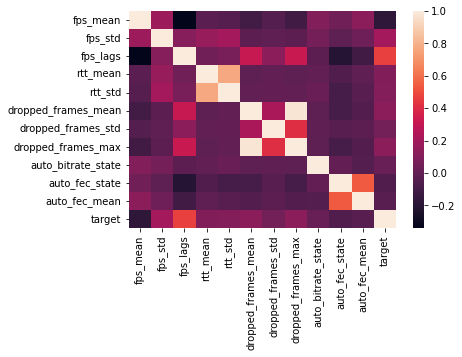

In [17]:
import seaborn as sns

sns.heatmap(X_train.assign(target=y_train).corr())

There is high positive correlation with fps_lags feature and negative correlation with fps_mean feature.

Automatic selection based on mutual information between features and target variable:

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

selector = SelectKBest(mutual_info_classif, k=8)

selector.fit(X_train_scaled, y_train)
selected_feats = X_train.columns[selector.get_support()]
print('Selected features with highest mutual inf: ', selected_feats.tolist())

Selected features with highest mutual inf:  ['fps_mean', 'fps_lags', 'rtt_mean', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max', 'auto_bitrate_state', 'auto_fec_state']


Selection based on importance of feature on performance of model:

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, RFE 

rfecv = RFECV(
    estimator=LogisticRegression(),
    step=1,
    cv=5,
    min_features_to_select=2
)
rfecv.fit(X_train_scaled, y_train)
imp_cols = X_train.columns[rfecv.support_]
print('Selected_features with rfecv: ',  imp_cols.tolist())

Selected_features with rfecv:  ['fps_mean', 'fps_std', 'fps_lags', 'dropped_frames_mean', 'dropped_frames_max']


## Model

In [21]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

def get_clf_metrics(y_true, y_pred):
    """
    Calculate classification metrics
    :param y_true: ground truth labels
    :param y_pred: predicted labels
    :return: calculated metrics
    """
    metrics = {'accuracy':accuracy_score(y_true, y_pred), 
              'precision':precision_score(y_true, y_pred),
              'recall':recall_score(y_true, y_pred),
              'f1':f1_score(y_true, y_pred)}
    
    return pd.Series(metrics)

In [22]:
def fit_predict(model, X_train, y_train, X_test):
    """
    Function to fit model and get predictions
    :param model: model to use
    :param X_train: train data
    :param y_train: target
    :param X_test: test data
    :return: predicted labels for train and test data
    """
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)    
    return y_pred_train, y_pred_test

def print_metrics(y_train, y_pred_train, y_test, y_pred_test):
    """
    Function to get train and test metrics
    :param y_train: train labels
    :param y_pred_train: predicted labels
    :param y_test: test labels
    :param y_pred_test: predicted test labels
    :return: DataFrame with test and train metrics
    """
    train_metrics = get_clf_metrics(y_train, y_pred_train)
    test_metrics = get_clf_metrics(y_test, y_pred_test)
    return pd.concat([train_metrics, test_metrics], axis=1, keys=['train', 'test'])

In [23]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

def get_clf_metrics(y_true, y_pred):
    """
    Calculate classification metrics
    :param y_true: ground truth labels
    :param y_pred: predicted labels
    :return: calculated metrics
    """
    metrics = {'accuracy':accuracy_score(y_true, y_pred), 
              'precision':precision_score(y_true, y_pred),
              'recall':recall_score(y_true, y_pred),
              'f1':f1_score(y_true, y_pred)}
    
    return pd.Series(metrics)

Training simple logistic regression model:

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

logreg = Pipeline([
    ('preprocess', StandardScaler()), 
    ('model', LogisticRegression(penalty='none'))
])

# evaluate model
y_pred_train, y_pred_test = fit_predict(logreg, X_train[imp_cols], y_train, X_test[imp_cols])
logreg_metrics = print_metrics(y_train, y_pred_train, y_test, y_pred_test)
logreg_metrics

,train,test
accuracy,0.944839,0.940923
precision,0.837137,0.721825
recall,0.241180,0.135083
f1,0.374474,0.227578


- Regularized models

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Logistic Regression with L2 regularization
logreg_l2 = Pipeline([
    ('preprocess', StandardScaler()), 
    ('model', LogisticRegression())
])

# tune regularization coefficient hyperparameter using cross validation
search_tool = RandomizedSearchCV(logreg_l2, 
                                 {'model__C':loguniform(1e-5, 1)}, 
                                 scoring='f1')

search_tool.fit(X_train[imp_cols], y_train)
print("Best parameter for C: ", search_tool.best_params_['model__C'])
print('Best  cross validation f1 score: ',  search_tool.best_score_)

# evaluate model
y_pred_train, y_pred_test = fit_predict(search_tool.best_estimator_, X_train[imp_cols], y_train, X_test[imp_cols])
l2_metrics = print_metrics(y_train, y_pred_train, y_test, y_pred_test)
l2_metrics

Best parameter for C:  0.5044986997156813
Best  cross validation f1 score:  0.3529014659387867


,train,test
accuracy,0.944590,0.940418
precision,0.841970,0.707309
recall,0.234677,0.128266
f1,0.367049,0.217152


In [32]:
# Logistic Regression with L1 regularization
logreg_l1 = Pipeline([
    ('preprocess', StandardScaler()), 
    ('model', LogisticRegression(max_iter=200, penalty="l1", solver="saga"))
])

# tune regularization coefficient hyperparameter using cross validation
search_tool = RandomizedSearchCV(logreg_l1, 
                                 {'model__C':loguniform(1e-5, 1)},
                                 scoring='f1')
search_tool.fit(X_train[imp_cols], y_train)
print("Best parameter for C: ", search_tool.best_params_['model__C'])
print('Best  cross validation f1 score: ',  search_tool.best_score_)

# evaluate model
y_pred_train, y_pred_test = fit_predict(search_tool.best_estimator_, X_train[imp_cols], y_train, X_test[imp_cols])
l1_metrics = print_metrics(y_train, y_pred_train, y_test, y_pred_test)
l1_metrics

Best parameter for C:  0.3407895009466769
Best  cross validation f1 score:  0.3530172277476102


,train,test
accuracy,0.944590,0.940414
precision,0.841970,0.707060
recall,0.234677,0.128266
f1,0.367049,0.217140


The performance of regularized models is similar

- Polynomial Features

In [30]:
# l2 regularized logistic regression with polynomial features
logreg_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('preprocess', StandardScaler()), 
    ('model', LogisticRegression(max_iter=200, penalty="l2"))
])

# tune regularization coefficient hyperparameter using cross validation
search_tool = RandomizedSearchCV(logreg_poly, 
                                 {'model__C':loguniform(1e-5, 10), 
                                 'poly__interaction_only':[True, False]},
                                 scoring='f1')
search_tool.fit(X_train[imp_cols], y_train)
print("Best parameter for C: ", search_tool.best_params_['model__C'])
print('Best  cross validation f1 score: ',  search_tool.best_score_)

# evaluate model
y_pred_train, y_pred_test = fit_predict(search_tool.best_estimator_, X_train[imp_cols], y_train, X_test[imp_cols])
poly_metrics = print_metrics(y_train, y_pred_train, y_test, y_pred_test)
poly_metrics

Best parameter for C:  0.08494888350175075
Best  cross validation f1 score:  0.3914040026610566


,train,test
accuracy,0.946376,0.942425
precision,0.842961,0.742235
recall,0.266329,0.162929
f1,0.404772,0.267203


Text(0.5, 1.0, 'Performance of models')

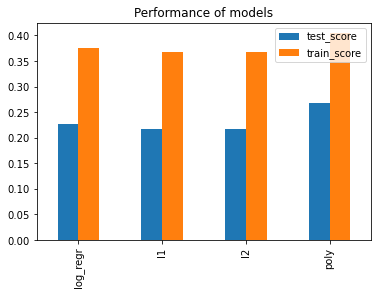

In [62]:
metric = 'f1'
metrics_test = {'log_regr':logreg_metrics['test'][metric], 
               'l1':l1_metrics['test'][metric], 
               'l2':l2_metrics['test'][metric], 
               'poly':poly_metrics['test'][metric]}
metrics_train = {'log_regr':logreg_metrics['train'][metric], 
               'l1':l1_metrics['train'][metric], 
               'l2':l2_metrics['train'][metric], 
               'poly':poly_metrics['train'][metric]}
metrics = pd.DataFrame([metrics_test, metrics_train], index=['test_score', 'train_score'])
metrics.T.plot.bar()
plt.title('Performance of models')
plt.ylabel('F1')
#plt.savefig('clf_f1.eps', format='eps')

## Outlier detection

Use interquartile range method to detect outliers:

In [41]:
# compute interquartile range
iqr = X_train[imp_cols].quantile(0.75) - X_train[imp_cols].quantile(0.25)
# upper bound for distribution
up_bound = X_train[imp_cols].quantile(0.75) + iqr * 1.5
# lower bound for distribution
low_bound = X_train[imp_cols].quantile(0.25) - iqr * 1.5
# select outliers which are higher than upper bound or lower than lower bound
outliers_mask = ((X_train[imp_cols] > up_bound) | (X_train[imp_cols] < low_bound)).sum(axis=1) > 0
X_train_clean = X_train[~outliers_mask][imp_cols].copy()
y_train_clean = y_train[~outliers_mask].copy()

print('Percentage of outliers: ', 1 - X_train_clean.shape[0] / X_train.shape[0])

Percentage of outliers:  0.12980234743169716


In [42]:
search_tool.fit(X_train_clean, y_train_clean)
logreg_poly['model'].C = search_tool.best_params_['model__C']
print("Best parameter for C: ", search_tool.best_params_['model__C'])
print('Best  cross validation f1 score: ',  search_tool.best_score_)

y_pred_train, y_pred_test = fit_predict(logreg_poly, X_train_clean, y_train_clean, X_test[imp_cols])
print_metrics(y_train_clean, y_pred_train, y_test, y_pred_test)

Best parameter for C:  0.0006251840501025531
Best  cross validation f1 score:  0.0


,train,test
accuracy,0.964726,0.935574
precision,0.000000,0.000000
recall,0.000000,0.000000
f1,0.000000,0.000000


Detecting outliers with interquantile range is not suitable in this case. There are many informative points dropped leading to poor performance. Perhaps the distribution of these variables originally has high variance

As univariate methods did not show improvement in performance, multivariate methods, such as density based outlier detection can be used:

In [43]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
outliers_mask = yhat == -1
X_train_clean = X_train[~outliers_mask][imp_cols]
y_train_clean = y_train[~outliers_mask]

vals, counts = np.unique(yhat, return_counts=True)
print('Percentage of outliers: ', counts[0] / train_data.shape[0])

Percentage of outliers:  0.03949853900416162


In [45]:
search_tool.fit(X_train_clean, y_train_clean)
logreg_poly['model'].C = search_tool.best_params_['model__C']
print("Best parameter for C: ", search_tool.best_params_['model__C'])
print('Best  cross validation f1 score: ',  search_tool.best_score_)

y_pred_train, y_pred_test = fit_predict(logreg_poly, X_train_clean, y_train_clean, X_test[imp_cols])
print_metrics(y_train_clean, y_pred_train, y_test, y_pred_test)

Best parameter for C:  0.19059321019880304
Best  cross validation f1 score:  0.3434901051291425


,train,test
accuracy,0.947948,0.942359
precision,0.829399,0.723439
recall,0.260447,0.170511
f1,0.396413,0.275976


The metrics show improvement of performance on data without outliers

## Class imbalance

The target labels are highly imbalanced:

In [46]:
print('Class distribution: ')
print(f'Class 1: {(y_train == 1).sum() / (y_train).count():f}')
print(f'Class 0: {(y_train == 0).sum() / (y_train).count():f}')

Class distribution: 
Class 1: 0.068460
Class 0: 0.931540


Perform balancing of data by adding random observations from minority class

In [55]:
from imblearn.pipeline import Pipeline as PipelineIm

logreg_over = PipelineIm([
    ('over', RandomOverSampler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('preprocess', StandardScaler()),
    ('model', LogisticRegression(max_iter=200, penalty="l2"))
])

search_tool = RandomizedSearchCV(logreg_over, {'model__C':loguniform(1e-5, 10), 
                                               'over__sampling_strategy':uniform(loc=0.1, scale=1)},
                                 scoring='f1')
search_tool.fit(X_train_clean, y_train_clean)
print("Best parameter for C: ", search_tool.best_params_['model__C'])
print("Best parameter for sampling: ", search_tool.best_params_['over__sampling_strategy'])
print("Best  cross validation f1 score: ",  search_tool.best_score_)

y_pred_train, y_pred_test = fit_predict(search_tool.best_estimator_, X_train_clean, y_train_clean, X_test[imp_cols])
oversample_metrics = print_metrics(y_train_clean, y_pred_train, y_test, y_pred_test)
oversample_metrics

Best parameter for C:  1.8952483362980919
Best parameter for sampling:  0.1636916813581414
Best  cross validation f1 score:  0.44591707253682344


,train,test
accuracy,0.944826,0.940754
precision,0.644674,0.582808
recall,0.354949,0.282974
f1,0.457826,0.380973


The performance of the model has been improved

New class distribution:

In [52]:
_, y_under = logreg_over[:1].fit_resample(X_train, y_train)
print('Class distribution: ')
print(f'Class 1: {(y_under == 1).sum() / (y_under).count():f}')
print(f'Class 0: {(y_under == 0).sum() / (y_under).count():f}')

Class distribution: 
Class 1: 0.223872
Class 0: 0.776128


Handling imbalanced data by randomly undersampling the majority class:

In [58]:
logreg_under = PipelineIm([
    ('over', RandomOverSampler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('preprocess', StandardScaler()),
    ('model', LogisticRegression(max_iter=200, penalty="l2"))
])

search_tool = RandomizedSearchCV(logreg_under, {'model__C':loguniform(1e-5, 10), 
                                               'over__sampling_strategy':uniform(loc=0.1, scale=1)},
                                 scoring='f1')
search_tool.fit(X_train_clean, y_train_clean)
print("Best parameter for C: ", search_tool.best_params_['model__C'])
print("Best parameter for sampling: ", search_tool.best_params_['over__sampling_strategy'])
print("Best  cross validation f1 score: ",  search_tool.best_score_)

y_pred_train, y_pred_test = fit_predict(search_tool.best_estimator_, 
                                        X_train_clean, y_train_clean, X_test[imp_cols])
undersample_metrics = print_metrics(y_train_clean, y_pred_train, y_test, y_pred_test)
undersample_metrics

Best parameter for C:  7.231703697030345
Best parameter for sampling:  0.2508043786486307
Best  cross validation f1 score:  0.4510064033352559


,train,test
accuracy,0.937354,0.933981
precision,0.529594,0.483024
recall,0.406727,0.351727
f1,0.460099,0.407050


New class distribution:

In [51]:
_, y_over = logreg_under[:1].fit_resample(X_train, y_train)
print('Class distribution: ')
print(f'Class 1: {(y_over == 1).sum() / (y_over).count():f}')
print(f'Class 0: {(y_over == 0).sum() / (y_over).count():f}')

Class distribution: 
Class 1: 0.319577
Class 0: 0.680423


Text(0, 0.5, 'F1')

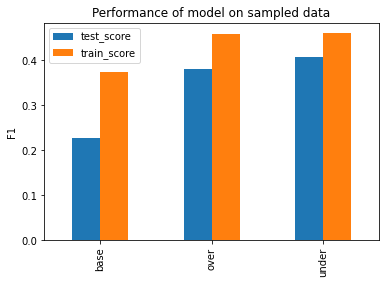

In [63]:
metric = 'f1'
metrics_test = {'base':logreg_metrics['test'][metric], 
               'over':oversample_metrics['test'][metric], 
               'under':undersample_metrics['test'][metric]}
metrics_train = {'base':logreg_metrics['train'][metric], 
               'over':oversample_metrics['train'][metric], 
               'under':undersample_metrics['train'][metric]}

metrics = pd.DataFrame([metrics_test, metrics_train], index=['test_score', 'train_score'])
metrics.T.plot.bar()
plt.title('Performance of model on sampled data')
plt.ylabel('F1')
#plt.savefig('imb.eps', format='eps')